In [12]:
import pandas as pd
from tqdm import tqdm
from top2vec import Top2Vec
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from pathlib import Path
import yaml 
import os

from helpers.linkage import *
from helpers import dataloader
from helpers.afa import adaptive_filter
from helpers.visuals import add_cabinet_periods
from helpers import metrics as mc
from helpers import infodynamics

cf = yaml.safe_load(Path('config.yml').read_text())

In [2]:
data = dataloader.load()
dists, labels, words, sem_col_translator = data['dists'],data['labels'],data['words'],data['translator']

In [3]:
# Create a dictionary of day:theta, get stats forr daily theta's
dict_date_theta = {d:_.to_numpy() for d,_ in dists.groupby(dists.index.to_period('M'))}
stats, mi_arrays = diachronic_linkage(dict_date_theta)

100%|██████████| 218/218 [00:15<00:00, 14.41it/s]


In [4]:
# Flatten MI-matrices, use only lower triangle, create a DataFrame
mi_arrays_flat = {k:flatten_mi_array(v) for k,v in tqdm(mi_arrays.items())}
dfm = pd.DataFrame({k:v[2].to_numpy() for k,v in mi_arrays_flat.items()}).T

100%|██████████| 218/218 [00:06<00:00, 31.63it/s]


In [5]:
# Create timestamps and matrix
timestamps = dfm.index.to_numpy()
theta = dfm.to_numpy()

In [6]:
def diachronic_correlations_lookback(theta,scale):
    mean_correlations = []
    for i in tqdm(range(scale,theta.shape[0])):
        lookback_window = theta[i:i+scale,:]
        m = np.array([np.correlate(theta[i,:],r) for r in lookback_window]).mean()
        mean_correlations.append(m)
    cdf = pd.DataFrame(list(zip(timestamps[scale:],mean_correlations)),columns=['date','corr'])
    cdf['c_afa'] = adaptive_filter(cdf['corr'],span=100)
    return cdf

In [8]:
cdf = diachronic_correlations_lookback(theta=theta,scale=12)

100%|██████████| 206/206 [00:00<00:00, 6479.29it/s]


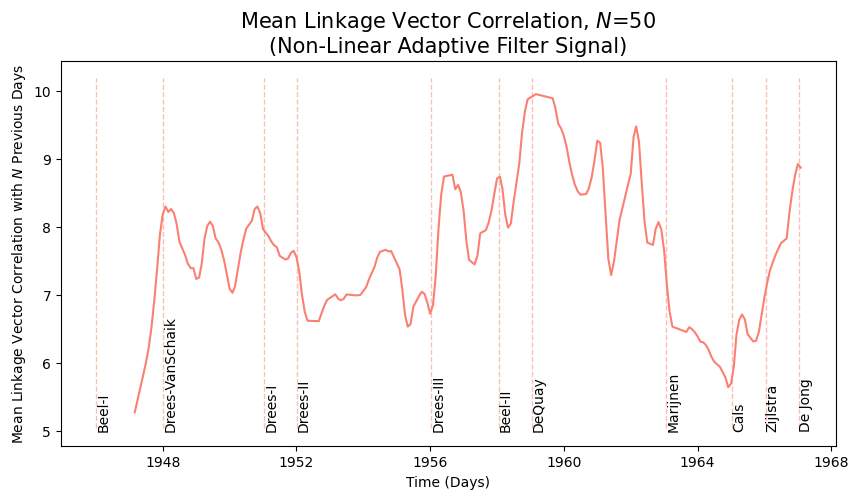

In [9]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(cdf.date.dt.to_timestamp(),cdf.c_afa,color='salmon')
ax.set_xlabel('Time (Days)')
ax.set_ylabel('Mean Linkage Vector Correlation with $\it{N}$ Previous Days')
ax.set_title('Mean Linkage Vector Correlation, $\it{N}$=50\n(Non-Linear Adaptive Filter Signal)',fontsize=15)
add_cabinet_periods(ax)
plt.savefig('figs/linkage-vector-corr-n12-month.pdf',dpi=250,bbox_inches='tight')
plt.show()

In [10]:
# Create probability distributions from theta
def zeroed(arr):
    return arr.clip(min=0)

def prob_dists(inputArray):
    vector = inputArray
    probabilityVector = np.zeros(vector.shape)
    for x in range(vector.shape[0]):
        new_vector = zeroed(vector[x])
        vectorSum = sum(new_vector)
        probabilityVector[[x]] = new_vector / vectorSum
    return probabilityVector 

In [11]:
theta = prob_dists(theta)

In [13]:
# Novelty

w = 12
im = infodynamics.InfoDynamics(theta,timestamps,w)
im = im.fit_return(meas=mc.jsd)
imd = pd.DataFrame(im)
imd['date'] = timestamps
imd['n_afa'] = adaptive_filter(imd.novelty,span=100)
imd['r_afa'] = adaptive_filter(imd.resonance,span=100)

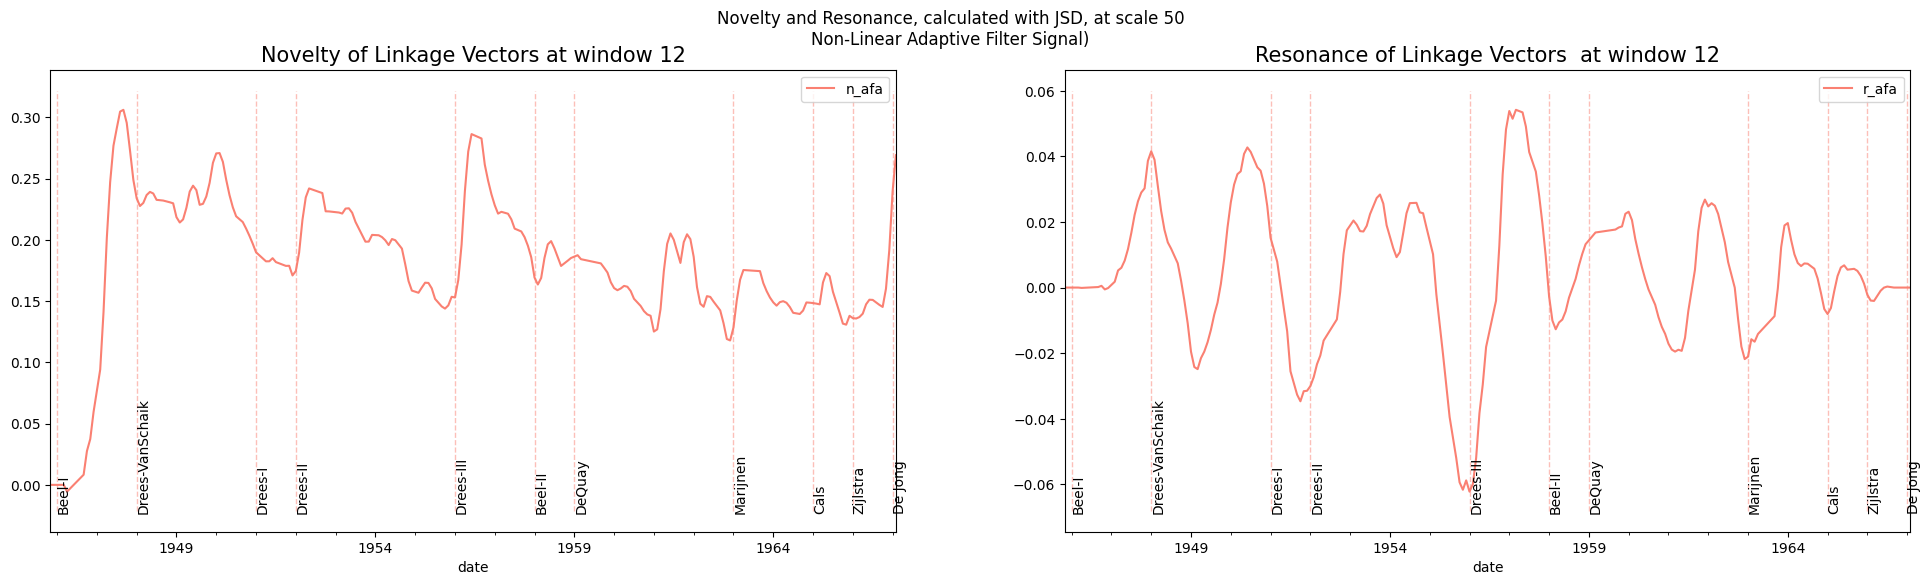

In [14]:

fig,ax = plt.subplots(1,2,figsize=(24,6))
imd.plot(x='date',y='n_afa',ax=ax[0],label=None,color='salmon')
imd.plot(x='date',y='r_afa',ax=ax[1],label=None,color='salmon')

ax[0].set_title(f'Novelty of Linkage Vectors at window {w}',fontsize=15)
ax[1].set_title(f'Resonance of Linkage Vectors  at window {w}',fontsize=15)
add_cabinet_periods(ax[0])
add_cabinet_periods(ax[1])

fig = plt.gcf()
fig.suptitle('Novelty and Resonance, calculated with JSD, at scale 50\nNon-Linear Adaptive Filter Signal)')
plt.savefig('figs/novelty-resonance-month.pdf',dpi=250)